# 目录
1. [简介](#1)
2. [基本原则](#2)
3. [导入包和选择设备](#3)
4. [导入图片](#4)
5. [损失函数](#5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.1 [内容损失](#5.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.2 [样式损失](#5.2)<br>
6. [导入模型](#6)
7. [梯度下降](#7)<br>

<div id="1"></div>

# 1 简介
本案例介绍了如何实现Leon A. Gatys，Alexander S. Ecker和Matthias Bethge开发的[神经风格算法](https://arxiv.org/abs/1508.06576)（Neural-Style algorithm）。使用神经风格或神经转换，可以在拍摄图像后，再以新的艺术风格再现它。

用户输入三个图像，分别为输入图像、内容图像、样式图像，该算法可将输入图片改变为内容像内容图片、艺术风格像样式图像的图片。

In [1]:
import torch
 
print(torch.__version__)
print(torch.cuda.is_available())

1.1.0
True


In [2]:
# x=torch.randn(1)
# if torch.cuda.is_available():
#     device=torch.device("cuda")
#     y=torch.ones_like(x,device=device)
#     x=x.to(device)
#     z=x+y
#     print(z)
#     print(z.to("cpu",torch.double))

In [3]:
%matplotlib inline

<div id="2"></div>

# 2 基本原则
原理很简单：我们定义两个距离，一个用于内容（$D_C$），一个用于样式（$D_S$）。$D_C$测量两个图像之间内容的差异，而$D_S$测量两个图像之间的样式的差异。当拍摄第三个图像（即输入）后，以最小化其与内容图像的内容距离及其与样式图像的样式距离为目标对其进行变换。现在我们可以导入必要的包并开始做神经转换。

<div id="3"></div>

# 3 导入包和选择设备
----------------------------------
以下是实现神经传递所需包的列表：

- `torch`，`torch.nn`，`numpy`（用PyTorch实现神经网络时不可或缺的包）
- `torch.optim`（高效梯度下降）
- `PIL`，`PIL.Image`，`matplotlib.pyplot`（加载和显示图像）
- `torchvision.transforms`（将PIL图像转换为张量）
- `torchvision.models`（训练或加载预训练模型）
- `copy`（深拷贝模型；系统包）

In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

接下来, 我们需要选择要在哪个设备(device)上运行神经网络、导入内容和样式图像。在大型图像上运行神经转移算法需要很长时间, 而使用GPU会大量提升运行速度。首先，我们可以使用`torch.cuda.is_available()`来检测GPU是否可用。接下来, 我们设置`torch.device`为在整个案例中使用。此外,`.to(device)`方法用于将张量或模块移动到所需的设备(device)。

In [2]:
# 保证在GPU与CPU都能运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div id="4"></div>

# 4 导入图片
现在, 我们将导入样式和内容图像：<br>
原始PIL图像的值介于0和255之间,将其转换为torch张量时,值需转换到0和1之间；还需要调整图像的大小,使其具有相同的尺寸。

需要注意的一个重要细节是,使用torch库建立神经网络所训练的张量值范围为[0,1]，如果使用范围为[0,255]的张量图像训练神经网络, 则激活的要素映射将无法感知所需的内容和样式。另外,来自Caffe库的预训练网络是用范围为[0,255]的张量图像训练的。


In [19]:
# 目标的输出图片大小
# imsize = 512 if torch.cuda.is_available() else 128  # 如果没有GPU则使用小尺寸图片
imsize = 512

# 对输入图片进行裁剪，转换成Tensor
loader = transforms.Compose([
    transforms.Resize(imsize),  # 缩放输入的图片
    transforms.ToTensor()])  # 转化成torch张量

# 封装了一个处理图片的函数
def image_loader(image_name):
    # 打开图片
    image = Image.open(image_name)
    # 利用定义的loader转换图片格式
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 利用定义的image_loader函数读取样式图与内容图
style_img = image_loader("./input/picasso.jpg")
content_img = image_loader("./input/dancing.jpg")

# 强调样式图与内容图的大小要是相同的
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [20]:
print(style_img.shape)
print(content_img.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


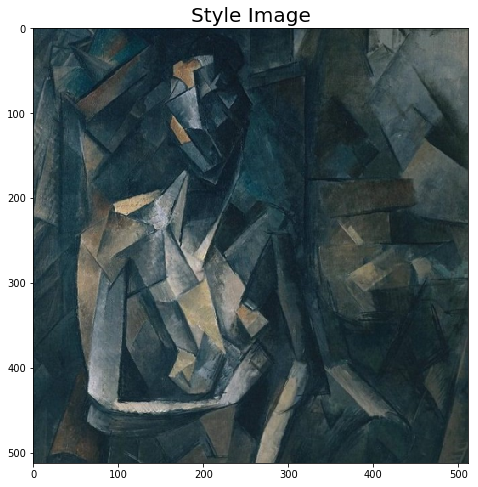

In [21]:
# 打印样式图片
show_input = style_img.detach().cpu().numpy() #tensor转化为np.array
show_input = np.transpose(show_input,(0,2,3,1))#调整维度数据，将原数据第二维调整到第四维。
# 将原始输入图像添加到图形中：
plt.figure(figsize=(8,8))
plt.title('Style Image',fontsize=20)
plt.imshow(show_input.reshape(512, 512, 3))

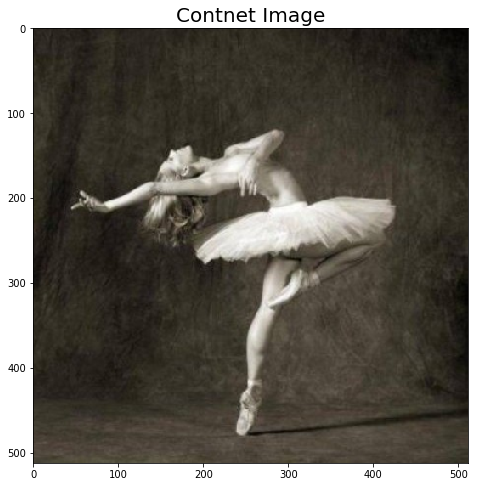

In [22]:
# 打印内容图片
show_input = content_img.detach().cpu().numpy() #tensor转化为np.array
show_input = np.transpose(show_input,(0,2,3,1))#调整维度数据，将原数据第二维调整到第四维。
# 将原始输入图像添加到图形中：
plt.figure(figsize=(8,8))
plt.title('Contnet Image',fontsize=20)
plt.imshow(show_input.reshape(512, 512, 3))


<div id="5"></div>

# 5 损失函数

<div id="5.1"></div>

## 5.1 内容损失函数
内容损失函数是单个层的内容距离的加权和。该函数使用在网络处理输入图像$X$中的层$L$处理特征映射$F_{XL}$，并返回图像$X$和内容图像$C$之间的加权内容距离$w_{CL}\cdot D_C^L(X,C)$。函数必须得到内容图像（$F_{CL}$）的特征图，进而才能计算内容距离。我们使用带有构造函数的torch模块实现这个函数，其中构造函数的输入为$F_{CL}$。距离$||F_{XL}-F_{CL}||^2$是两组特征图之间的均方误差，可以使用`nn.MSELoss`计算。

我们将在用于计算内容距离的卷积层之后直接添加此内容的损失模块。这样，每次向网络传入一个输入图像时，将在期望的层计算内容损失，并且auto grad将自动计算所有梯度。我们必须定义一个可以计算内容损失和前向传播的`forward`方法。计算的损失将作为一个参数保存在模块里。

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        #我们从用于动态计算梯度的树中 "分离" 目标内容: 这是一个声明的值, 而不是一个变量。
        #否则, forward方法将引发错误。
        self.target = target.detach()

    def forward(self, input):
        # 均方误差
        self.loss = F.mse_loss(input, self.target)
        return input

**重要的细节**: 虽然这个模块被命名为ContentLoss,但它不是一个真正的PyTorch损失函数。如果要将内容损失函数定义为 PyTorch损失函数,则必须创建一个PyTorch autograd 函数,以便在`backward`方法中手动实现梯度算法。

<div id="5.2"></div>

## 5.2 样式损失函数

样式损失模块的实现类似于内容损失模块。<br>

它将作为网络中的一个透明层, 计算该层的样式损失。为了计算样式损失, 我们需要计算Gram矩阵$G_{XL}$。

**Gram矩阵是将给定矩阵乘以其转置矩阵**，即：$G_{XL}=\hat{F}_{KL}\cdot \hat{F}_{KL}^{T}$.<br>
给定矩阵$\hat F_{XL}$是层$L$的特征映射$F_{XL}$的变形, 其为一个$K \times N$矩阵, 其中$K$是$L$层的特征映射的数量,$N$是向量化特征映射$F_{XL}^k$的长度。其中$ F_{XL}^{k}$是$\hat{F}_{XL}$第$k$行。

最后, Gram矩阵必须通过将每个元素除以矩阵中元素的总数来归一化。这种归一化是为了抵消具有维数$N$较大的$\hat F_{XL}$的Gram矩阵产生较大值的问题。这些较大的值将在第一层 (在池化层前) 的梯度下降过程中产生较大影响。

样式特征往往位于网络的深层, 因此此规范化步骤至关重要。

In [5]:
# 定义Gram矩阵
def gram_matrix(input):
    # a = batch size(=1)
    # b = number of feature maps
    # (c,d) = dimensions of a f. map (N = c * d)
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)   # 得到给定矩阵 \hat{F}_{KL}

    G = torch.mm(features, features.t())  # 得到 Gram矩阵

    # 我们通过除以每个要素图中的元素数来 "归一化" Gram矩阵的值。
    return G.div(a * b * c * d)

样式损失函数模块看起来几乎与内容损失函数模块相同，使用$G_{XL}$和$G_{SL}$之间的均方误差计算样式距离。

In [6]:
# 与之前定义的ContentLoss类相似
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # 利用定义的Gram矩阵
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        # 同样使用均方误差
        self.loss = F.mse_loss(G, self.target)
        return input

<div id="6"></div>

# 6 导入模型
现在我们需要导入一个已经预训练的神经网络。我们将使用一个19层的VGG网络。

PyTorch对VGG的实现是一整个模块,分为两个子序列`Sequential`模块: 特征`features` (包含卷积和池层) 和分类器`classifier` (包含完全连接的层)。

我们将使用`features`模块, 因为我们需要单个卷积图层的输出来计算内容和样式损失。有些层在训练与评价的过程中有不同的行为, 因此我们必须使用`.eval()`将网络设置为评价模式。

In [ ]:
# 导入已经预训练的VGG网络模型
cnn = models.vgg19(pretrained=True).features.to(device).eval()

此外,VGG网络还接受图像训练, 每个通道按$mean=[0.485，0.56，0.406]$和$std=[0.229,0.224,0.225]$归一化。在将图片输入到网络之前, 我们将使用它们规范化图片。

In [12]:
# 给定标准化的mean与std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 定义对输入的图片做标准化的类
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # 标准化 img
        return (img - self.mean) / self.std

`Sequential`模块包含子模块的有序列表。<br>

例如,`vgg19.features`包含一个序列(Conv2d、ReLU、Maxpool2d、Conv2d、ReLU...),按正确的深度顺序排列。我们需要在它们检测到的卷积层之后立即添加内容损失函数层和样式损失函数层。为此,我们必须创建一个新的`Sequential`模块, 正确插入内容损失函数和样式损失函数模块。

In [13]:
# 样式/内容损失所需的深度层 :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 导入vgg网络
    cnn = copy.deepcopy(cnn)

    # 做标准化
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 内容/样式损失函数
    content_losses = []
    style_losses = []

    # 假设 cnn 是一个 nn.Sequential, 
    # 所以我们做了一个新的nn.Sequential放入应该按顺序激活的模块中
    model = nn.Sequential(normalization)
    
    # 构建cnn中的层
    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # in-place版本与我们插在下面的内容损失和样式丢失不匹配
            # 所以我们在这里用out-of-place的来代替
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 加内容损失函数:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # 加样式损失函数:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 现在, 我们修剪在最后的内容和样式损失的之后的层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

接下来, 我们输入图片，可以使用内容图片或白噪声的拷贝。

In [14]:
input_img = content_img.clone()
# 如果你想使用白噪声, 请取消注释下面的行:
#input_img = torch.randn(content_img.data.size(), device=device)
print(input_img.shape)

torch.Size([1, 3, 512, 512])


因为`plt.imshow()`支持的图像格式是(高度，宽度，通道)，因此`input_img`需要调整后再显示。需要注意的是，调整维度顺序时`reshape`方法并不能真正调整顺序，一般我们通过`transpose`方法进行调整。

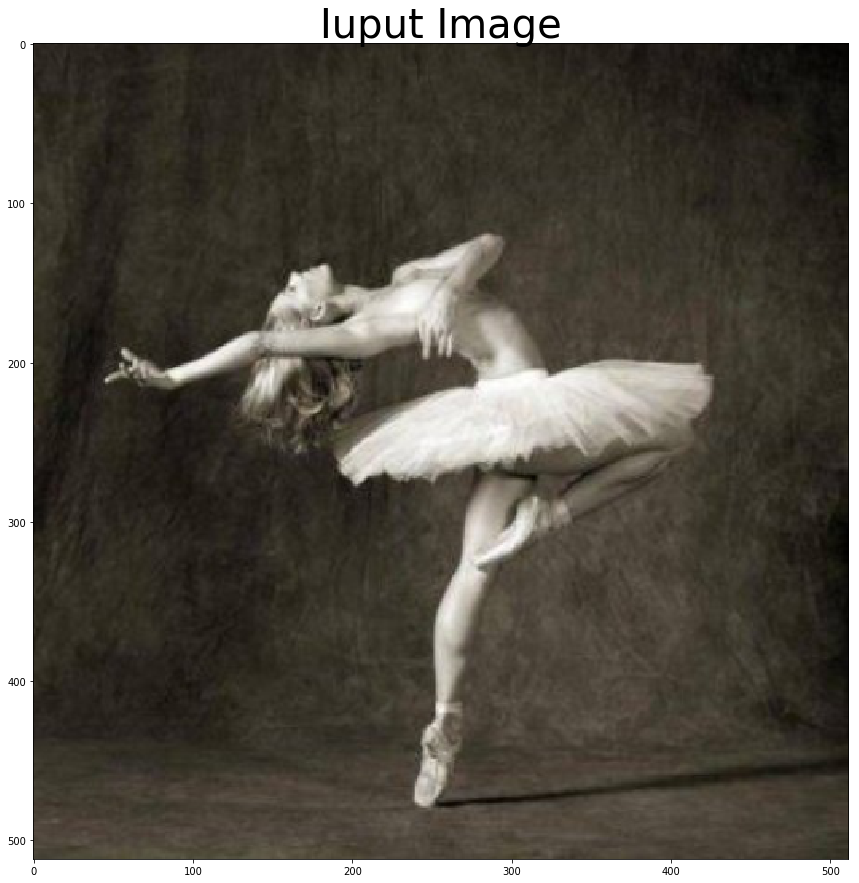

In [24]:
show_input = input_img.detach().cpu().numpy() #tensor转化为np.array
show_input = np.transpose(show_input,(0,2,3,1))#调整维度数据，将原数据第二维调整到第四维。
# 将原始输入图像添加到图形中：
plt.figure(figsize=(15,15))
plt.title('Iuput Image',fontsize=40)
plt.imshow(show_input.reshape(512, 512, 3))

<div id="7"></div>

# 7 梯度下降
我们将使用L-BFGS算法来运行梯度下降。

与训练网络不同, 我们希望训练输入图像, 以最大限度地减少内容或样式的损失。我们将创建一个PyTorch L-BFGS优化器`optim.LBFGS`,并将图片作为张量传入来进行优化。

In [25]:
def get_input_optimizer(input_img):
    # 显示输入是一个参数, 需要传入梯度
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

最后, 我们必须定义一个执行神经转换的函数。网络每一次迭代, 都会提供更新的输入并计算新的损失。我们将运行每个损失模块的`backward`方法, 以动态地计算它们的梯度。优化器需要一个`closure`函数, 该函数重新评价模块并返回损失值。

我们还有最后一个问题需要解决，网络可能会尝试优化超过张量范围[0,1]的输入。我们可以通过在每次运行网络时将输入值更正为0到1之间来解决这个问题。

In [26]:
# 定义样式转换函数  num_steps = 300   style_weight = 1000000   content_weight = 1
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    # 根据之前定义的函数得到model，style_losses，content_losses
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    #　优化器
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 更正更新后的输入图像的值，即将输入值限制在（0，1）之间
            input_img.data.clamp_(0, 1)
            
            # 权值初始化
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            # 获取样式损失和内容损失
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            # 最终loss由样式损失和内容损失共同构成
            loss = style_score + content_score
            # 梯度反向传播
            loss.backward()

            run[0] += 1
            # 每50次做一次输出 Style Loss、Content Loss
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        #　权值更新
        optimizer.step(closure)

    # 最后做一次修正 --> (0,1)
    input_img.data.clamp_(0, 1)

    return input_img

最后, 我们可以运行该算法。

Building the style transfer model..


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Optimizing..
run [50]:
Style Loss : 0.148651 Content Loss: 2.232573

run [100]:
Style Loss : 0.147650 Content Loss: 2.225936

run [150]:
Style Loss : 0.147246 Content Loss: 2.221522

run [200]:
Style Loss : 0.146082 Content Loss: 2.217686

run [250]:
Style Loss : 0.144685 Content Loss: 2.215087

run [300]:
Style Loss : 0.143079 Content Loss: 2.212098



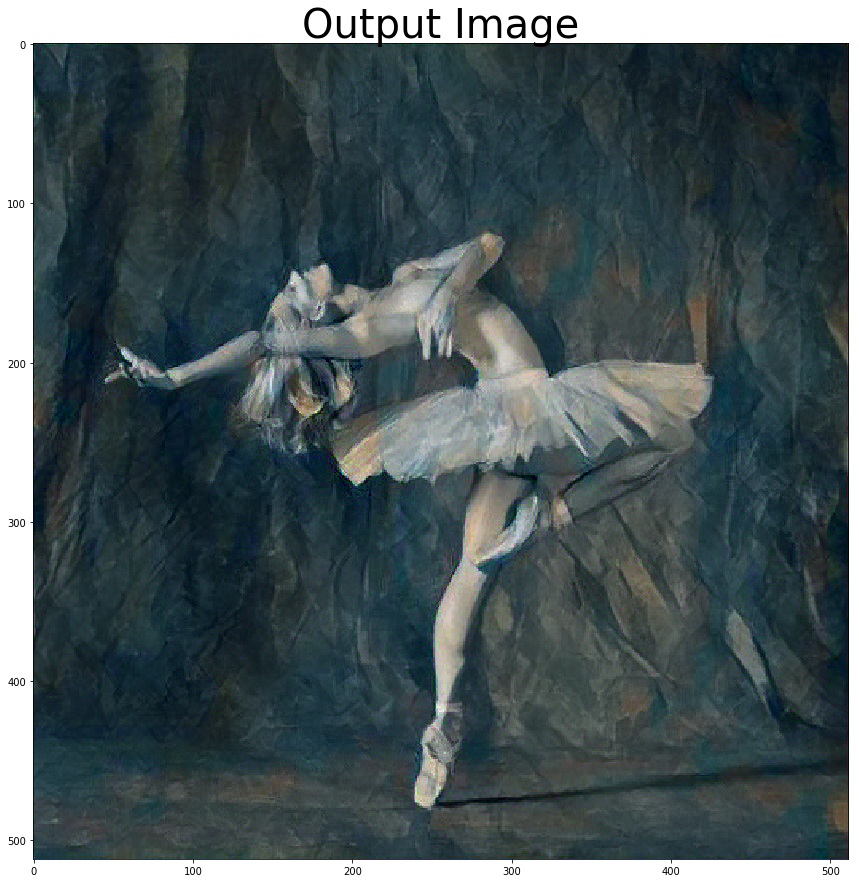

In [29]:
# 输出值
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
output = output.detach().cpu().numpy()
output = np.transpose(output,(0,2,3,1))

# 打印生成的风格图片
plt.figure(figsize=(15,15))
plt.title('Output Image',fontsize=40)
plt.imshow(output.reshape(512,512,3))

plt.ioff()
plt.show()